In [1]:
from keras.optimizers import Adam
from models import build_transmitter_model, build_receiver_model
from keras.utils import to_categorical
from keras import Model
import tensorflow as tf
from keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping
import pickle
import os 
import random
import collections
import matplotlib.pyplot as plt
import h5py
from keras.models import load_model
import numpy as np

2023-06-18 23:34:12.250210: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-18 23:34:14.804932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 23:34:15.196522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22293 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [2]:
train_acc_metric = CategoricalAccuracy()
val_acc_metric = CategoricalAccuracy()

In [3]:
class ClevrDataset(tf.keras.utils.Sequence):
    def __init__(self, data_dir, split='train'):
        with open(os.path.join(data_dir, '{}.pkl'.format(split)), 'rb') as f:
            self.data = pickle.load(f)

        self.data_dict = collections.defaultdict(list)
        for item in self.data:
            _, _, answer, _ = item
            self.data_dict[answer].append(item)

        self.shuffle()
        self.img = h5py.File(os.path.join(data_dir, 'image_{}.h5'.format(split)), 'r')
        self.max_question_length = 46  # max_len + 1
        self.num_classes = 28  # max_len + 1

    def shuffle(self):
        self.data = []
        for _, items in self.data_dict.items():
            self.data += items
        random.shuffle(self.data)

    def get_max_answer(self):
        max_answer = 0
        for index in range(len(self.data)):
            _, _, answer, _ = self.data[index]
            if answer > max_answer:
                max_answer = answer
        return max_answer + 1

    def get_max_question_length(self):
        max_len = 0
        for index in range(len(self.data)):
            _, question, _, _ = self.data[index]
            if len(question) > max_len:
                max_len = len(question)
        return max_len + 1

    def pad_question(self, question):
        if len(question) >= self.max_question_length:
            question_padded = question[:self.max_question_length]
        else:
            question_padded = question + [0] * (self.max_question_length - len(question))
        return question_padded

    def __getitem__(self, index):
        imgfile, question, answer, family = self.data[index]
        id = int(imgfile.rsplit('_', 1)[1][:-4])
        img = tf.convert_to_tensor(self.img[f'image_{id}'][()] / 255., dtype=tf.float32)

        # Padding
        question_padded = self.pad_question(question)
        return img, question_padded, to_categorical(answer, num_classes=self.num_classes)

    def __len__(self):
        return len(self.data)

In [4]:
tx_model = build_transmitter_model()
rx_model = build_receiver_model()

train_dataset = ClevrDataset(data_dir='data/', split="train")

train_dataloader = tf.data.Dataset.from_generator(lambda: train_dataset,
                output_signature=(
                tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(46), dtype=tf.int32),
                tf.TensorSpec(shape=(28), dtype=tf.int32),))
train_dataloader = train_dataloader.batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = ClevrDataset(data_dir='data/', split="val")

val_dataloader = tf.data.Dataset.from_generator(lambda: val_dataset,
                output_signature=(
                tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(46), dtype=tf.int32),
                tf.TensorSpec(shape=(28), dtype=tf.int32),))
val_dataloader = val_dataloader.batch(64).prefetch(tf.data.AUTOTUNE)

In [5]:
opt = Adam(learning_rate=1e-4)
tx_output = tx_model.output

cls_output = rx_model(tx_output)
sc_model = Model(inputs=tx_model.input, outputs=cls_output, name="sc_model")
sc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

keras_callbacks   = [
    EarlyStopping(monitor='val_loss', patience=2, mode='min', min_delta=0.0001)
]

history = sc_model.fit(train_dataloader.map(lambda x, y, z: ((x, y), z)), \
                validation_data=(val_dataloader.map(lambda x, y, z: ((x, y), z))), epochs=10, callbacks=keras_callbacks)

Epoch 1/10


2023-06-18 23:34:48.395561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-06-18 23:34:48.873392: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10938/10938 [==============================] - 7135s 650ms/step - loss: 1.0421 - acc: 0.4332 - val_loss: 0.9874 - val_acc: 0.4528
Epoch 2/10
10938/10938 [==============================] - 7287s 666ms/step - loss: 0.9653 - acc: 0.4685 - val_loss: 0.9649 - val_acc: 0.4696
Epoch 3/10
10938/10938 [==============================] - 6809s 622ms/step - loss: 0.9515 - acc: 0.4786 - val_loss: 0.9598 - val_acc: 0.4716
Epoch 4/10
10938/10938 [==============================] - 6491s 593ms/step - loss: 0.9491 - acc: 0.4841 - val_loss: 0.9517 - val_acc: 0.4831
Epoch 5/10
10938/10938 [==============================] - 6916s 632ms/step - loss: 1.0104 - acc: 0.4608 - val_loss: 0.9540 - val_acc: 0.4763
Epoch 6/10
10938/10938 [==============================] - 7166s 655ms/step - loss: 0.9493 - acc: 0.4826 - val_loss: 0.9887 - val_acc: 0.4652


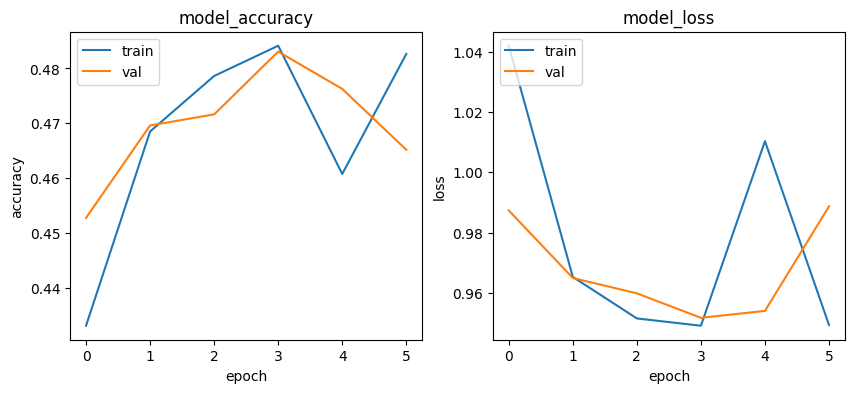

In [7]:
# plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, y_label_list):
    num_graphs = len(graph_labels)
    plt.figure(figsize=(5*num_graphs,4))
    for i in range(num_graphs):
        plt.subplot(1,num_graphs,i+1)
        plt.plot(log_history.history[log_labels[2 * i]])
        plt.plot(log_history.history[log_labels[2 * i + 1]])
        plt.title(graph_labels[i])
        plt.xlabel('epoch')
        plt.ylabel(y_label_list[i])
        plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return

label_strings = ['acc', 'val_acc', 'loss', 'val_loss']
graph_labels    = ['model_accuracy', 'model_loss']
y_label_list = ['accuracy', 'loss']

plot_graphs(history, label_strings, graph_labels, y_label_list)

In [8]:
def save_weights_process(tx_model, rx_model):
    tx_model.save("tx_model.h5")
    np.save('rx_model_weights.npy', rx_model.get_weights())

In [9]:
sc_model_weights = sc_model.get_weights()
tx_model_weights = sc_model_weights[:len(tx_model.weights)]
rx_model_weights = sc_model_weights[len(tx_model.weights):]

tx_model.set_weights(tx_model_weights)
rx_model.set_weights(rx_model_weights)

save_weights_process(tx_model, rx_model)

/home/sjh/env-sc/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
